# Trabajo Práctico 1: Enunciado


El trabajo práctico 1 de la materia se basa en el análisis de los tweets del set de datos de la competencia: https://www.kaggle.com/c/nlp-getting-started.  

- id - identificador unico para cada  tweet
- text - el texto del tweet
- location - ubicación desde donde fue enviado (podría no estar)
- keyword - un keyword para el tweet  (podría faltar)
- target - en train.csv, indica si se trata de un desastre real  (1) o no (0)

El objetivo del primer TP es realizar un análisis exploratorio del set de datos. Queremos ver qué cosas podemos descubrir sobre los datos que puedan resultar interesantes. Estas cosas pueden estar relacionadas al objetivo del TP2 (predecir si un cierto tweet es real o no) o no, ambas son de interés.

Los requisitos de la primera entrega son los siguientes:

- El análisis debe estar hecho en Python Pandas o R.
- El análisis debe entregarse en formato pdf vía gradescope. En el informe no va código.
- Informar el link a un repositorio Github en donde pueda bajarse el código completo para generar el análisis.

La evaluación del TP se realizará en base al siguiente criterio:

- Originalidad del análisis exploratorio. 
- Calidad del reporte. ¿Está bien escrito? ¿Es claro y preciso? 
- Calidad del análisis exploratorio: qué tipo de preguntas se hacen y de qué forma se responden, ¿es la respuesta clara y concisa con respecto a la pregunta formulada? 
- Calidad de las visualizaciones presentadas.
  - ¿Tienen todos los ejes su rótulo?
  - ¿Tiene cada visualización un título?
  - ¿Es entendible la visualización sin tener que leer la explicación?
  - ¿El tipo de plot elegido es adecuado para lo que se quiere visualizar?
  - ¿Es una visualización interesante?
  - ¿El uso del color es adecuado?
  - ¿Hay un exceso o falta de elementos visuales en la visualización elegida?
  - ¿La visualización es consistente con los datos?
- Conclusiones presentadas.


In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs


/home/coquita/.pyenv/pyenv/versions/3.6.1/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [50]:
tweets = pd.read_csv('../data/train.csv', encoding='utf-8')
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [51]:
tweets.keyword.value_counts()

fatalities               45
armageddon               42
deluge                   42
harm                     41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [52]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [53]:
# keyword tiene 61 nulls
# location tiene 2533 nulls

In [54]:
tweets.location.value_counts() # se podría unificar varios a USA

USA                         104
New York                     71
United States                50
London                       45
Canada                       29
                           ... 
No ID, No VOTE!!!             1
someplace living my life      1
Los Angeles for now           1
denver colorado               1
The Desert                    1
Name: location, Length: 3341, dtype: int64

### Análisis de los falsos

In [55]:
tweets[tweets["target"] == 0]["text"] #los falsos

15                                         What's up man?
16                                          I love fruits
17                                       Summer is lovely
18                                      My car is so fast
19                           What a goooooooaaaaaal!!!!!!
                              ...                        
7581    @engineshed Great atmosphere at the British Li...
7582    Cramer: Iger's 3 words that wrecked Disney's s...
7584    These boxes are ready to explode! Exploding Ki...
7587                                   Sirens everywhere!
7593    I just heard a really loud bang and everyone i...
Name: text, Length: 4342, dtype: object

In [56]:
tweets[tweets["target"] == 0].keyword.value_counts() #los falsos, keywords

body%20bags          40
harm                 37
armageddon           37
wrecked              36
ruin                 36
                     ..
suicide%20bomber      1
suicide%20bombing     1
typhoon               1
oil%20spill           1
outbreak              1
Name: keyword, Length: 218, dtype: int64

### Análisis de los posta

In [57]:
tweets[tweets["target"] == 1]["text"] #los posta

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 3271, dtype: object

In [58]:
tweets[tweets["target"] == 1].keyword.value_counts() #los posta, keywords

wreckage       39
outbreak       39
derailment     39
oil%20spill    37
debris         37
               ..
electrocute     1
blazing         1
ruin            1
body%20bags     1
body%20bag      1
Name: keyword, Length: 220, dtype: int64

### Análisis de los textos

#### Eliminando palabras que no son super importantes

In [59]:
!pip install nltk
!pip install stopwords

You should consider upgrading via the '/home/coquita/.pyenv/pyenv/versions/3.6.1/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/coquita/.pyenv/pyenv/versions/3.6.1/bin/python3.6 -m pip install --upgrade pip' command.


In [60]:
#import nltkfrom nltk.corpus 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/coquita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
stop_words = stopwords.words('english')
stop_words[1:15]

['me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours']

In [62]:
# eliminamos las stop words de los textos
# convertimos el texto en listado de palabras y despues borramos las stop words
tweets['words'] =tweets.text.str.lower().str.split()
tweets['normalized_words'] = tweets['words'].apply(lambda x: [item for item in x if item not in stop_words])

In [63]:
tweets.head()

,id,keyword,location,text,target,words,normalized_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, #eart...","[deeds, reason, #earthquake, may, allah, forgi..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask., canada]","[forest, fire, near, la, ronge, sask., canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, 'shelter, in, plac...","[residents, asked, 'shelter, place', notified,..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, #wildfires, evacuati...","[13,000, people, receive, #wildfires, evacuati..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, #al...","[got, sent, photo, ruby, #alaska, smoke, #wild..."


#### Bag of Words

In [64]:
from collections import Counter
# contamos la cantidad de palabras de cada tweet
tweets['words_counter'] = tweets.normalized_words.apply(Counter)

In [65]:
tweets.head()

,id,keyword,location,text,target,words,normalized_words,words_counter
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, #eart...","[deeds, reason, #earthquake, may, allah, forgi...","{'deeds': 1, 'reason': 1, '#earthquake': 1, 'm..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask., canada]","[forest, fire, near, la, ronge, sask., canada]","{'forest': 1, 'fire': 1, 'near': 1, 'la': 1, '..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, 'shelter, in, plac...","[residents, asked, 'shelter, place', notified,...","{'residents': 1, 'asked': 1, ''shelter': 1, 'p..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, #wildfires, evacuati...","[13,000, people, receive, #wildfires, evacuati...","{'13,000': 1, 'people': 1, 'receive': 1, '#wil..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, #al...","[got, sent, photo, ruby, #alaska, smoke, #wild...","{'got': 1, 'sent': 1, 'photo': 1, 'ruby': 1, '..."


#### Contador de links (DESCARTADO)
Quiero ver si hay relación entre cantidad de tweets fakes y no fakes y la cantidad de links (DESCARTADO)

In [66]:
# cuento la cantidad de links en los tweets
import re
URLPATTERN = r'(https?://\S+)' 
# nueva columna con el total de links
tweets['url_count'] = tweets.text.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
tweets.head()

,id,keyword,location,text,target,words,normalized_words,words_counter,url_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, #eart...","[deeds, reason, #earthquake, may, allah, forgi...","{'deeds': 1, 'reason': 1, '#earthquake': 1, 'm...",0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask., canada]","[forest, fire, near, la, ronge, sask., canada]","{'forest': 1, 'fire': 1, 'near': 1, 'la': 1, '...",0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, 'shelter, in, plac...","[residents, asked, 'shelter, place', notified,...","{'residents': 1, 'asked': 1, ''shelter': 1, 'p...",0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, #wildfires, evacuati...","[13,000, people, receive, #wildfires, evacuati...","{'13,000': 1, 'people': 1, 'receive': 1, '#wil...",0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, #al...","[got, sent, photo, ruby, #alaska, smoke, #wild...","{'got': 1, 'sent': 1, 'photo': 1, 'ruby': 1, '...",0


In [67]:
tweets[tweets["target"] == 1].url_count.value_counts() #los posta, cantidad de urls

1    1835
0    1099
2     328
3       9
Name: url_count, dtype: int64

In [68]:
tweets[tweets["target"] == 0].url_count.value_counts() #los fake, cantidad de urls

0    2543
1    1414
2     369
3      13
4       3
Name: url_count, dtype: int64

Text(0, 0.5, 'Cantidad de links')

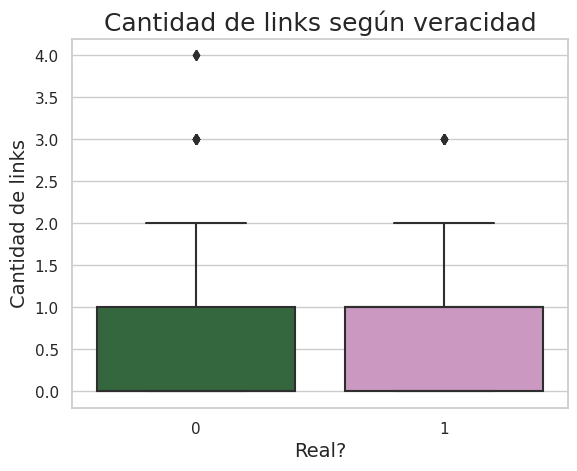

In [69]:
# grafico esto para ver si hay relación
g = sns.boxplot(x="target", y="url_count", 
                     data=tweets, palette="cubehelix")
g.set_title("Cantidad de links según veracidad", fontsize=18)
g.set_xlabel("Real?", fontsize=14)
g.set_ylabel("Cantidad de links", fontsize=14)

#### Contador de hashtags 
Quiero ver si hay relación entre cantidad de tweets fakes y no fakes y la cantidad de hashtags 

In [70]:
# cuento la cantidad de hashtags en los tweets
# nueva columna con el total de hashtags, y los hashtags
tweets['hashtags'] = tweets.text.apply(lambda x: re.findall(r"#(\w+)", x))
tweets.head()


,id,keyword,location,text,target,words,normalized_words,words_counter,url_count,hashtags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, #eart...","[deeds, reason, #earthquake, may, allah, forgi...","{'deeds': 1, 'reason': 1, '#earthquake': 1, 'm...",0,[earthquake]
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask., canada]","[forest, fire, near, la, ronge, sask., canada]","{'forest': 1, 'fire': 1, 'near': 1, 'la': 1, '...",0,[]
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, 'shelter, in, plac...","[residents, asked, 'shelter, place', notified,...","{'residents': 1, 'asked': 1, ''shelter': 1, 'p...",0,[]
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, #wildfires, evacuati...","[13,000, people, receive, #wildfires, evacuati...","{'13,000': 1, 'people': 1, 'receive': 1, '#wil...",0,[wildfires]
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, #al...","[got, sent, photo, ruby, #alaska, smoke, #wild...","{'got': 1, 'sent': 1, 'photo': 1, 'ruby': 1, '...",0,"[Alaska, wildfires]"


In [71]:
tweets['hashtags_count'] = tweets.hashtags.str.len()
tweets.head()

,id,keyword,location,text,target,words,normalized_words,words_counter,url_count,hashtags,hashtags_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, #eart...","[deeds, reason, #earthquake, may, allah, forgi...","{'deeds': 1, 'reason': 1, '#earthquake': 1, 'm...",0,[earthquake],1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask., canada]","[forest, fire, near, la, ronge, sask., canada]","{'forest': 1, 'fire': 1, 'near': 1, 'la': 1, '...",0,[],0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, 'shelter, in, plac...","[residents, asked, 'shelter, place', notified,...","{'residents': 1, 'asked': 1, ''shelter': 1, 'p...",0,[],0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, #wildfires, evacuati...","[13,000, people, receive, #wildfires, evacuati...","{'13,000': 1, 'people': 1, 'receive': 1, '#wil...",0,[wildfires],1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, #al...","[got, sent, photo, ruby, #alaska, smoke, #wild...","{'got': 1, 'sent': 1, 'photo': 1, 'ruby': 1, '...",0,"[Alaska, wildfires]",2


In [72]:
# todos los hashtags
tweets.text.str.extractall(r'(\#\w+)')[0].value_counts()


#news            38
#News            38
#hot             31
#prebreak        30
#best            30
                 ..
#iwontmakeit      1
#Borderlands2     1
#TRAITOR          1
#watersafety      1
#bigbrother       1
Name: 0, Length: 2087, dtype: int64

In [73]:
tweets[tweets["target"] == 1].hashtags_count.value_counts() #los posta

0     2413
1      478
2      208
3       94
4       27
5       22
10       7
8        7
6        7
13       4
7        4
Name: hashtags_count, dtype: int64

In [74]:
tweets[tweets["target"] == 0].hashtags_count.value_counts() #los fake}

0     3457
1      486
2      199
3      108
4       44
6       20
5       17
7        3
10       3
11       2
9        2
8        1
Name: hashtags_count, dtype: int64

Text(0, 0.5, 'Cantidad de hashtags')

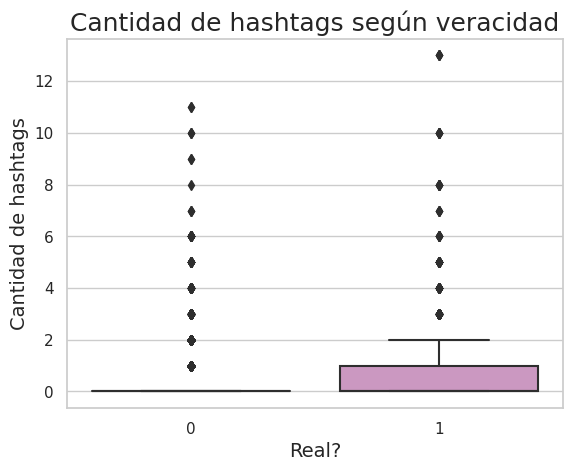

In [75]:
# grafico esto para ver si hay relación
g = sns.boxplot(x="target", y="hashtags_count", 
                     data=tweets, palette="cubehelix")
g.set_title("Cantidad de hashtags según veracidad", fontsize=18)
g.set_xlabel("Real?", fontsize=14)
g.set_ylabel("Cantidad de hashtags", fontsize=14)

#### Contador de tags 
Quiero ver si hay relación entre cantidad de tweets fakes y no fakes y la cantidad de tags 

In [82]:
# cuento la cantidad de ags en los tweets
# nueva columna con el total de tags, y los tags
tweets['tags'] = tweets.text.apply(lambda x: re.findall(r"@(\w+)", x))
tweets.head()


,id,keyword,location,text,target,words,normalized_words,words_counter,url_count,hashtags,hashtags_count,tags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, #eart...","[deeds, reason, #earthquake, may, allah, forgi...","{'deeds': 1, 'reason': 1, '#earthquake': 1, 'm...",0,[earthquake],1,[]
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask., canada]","[forest, fire, near, la, ronge, sask., canada]","{'forest': 1, 'fire': 1, 'near': 1, 'la': 1, '...",0,[],0,[]
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, 'shelter, in, plac...","[residents, asked, 'shelter, place', notified,...","{'residents': 1, 'asked': 1, ''shelter': 1, 'p...",0,[],0,[]
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, #wildfires, evacuati...","[13,000, people, receive, #wildfires, evacuati...","{'13,000': 1, 'people': 1, 'receive': 1, '#wil...",0,[wildfires],1,[]
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, #al...","[got, sent, photo, ruby, #alaska, smoke, #wild...","{'got': 1, 'sent': 1, 'photo': 1, 'ruby': 1, '...",0,"[Alaska, wildfires]",2,[]


In [83]:
tweets['tags_count'] = tweets.tags.str.len()
tweets.head()

,id,keyword,location,text,target,words,normalized_words,words_counter,url_count,hashtags,hashtags_count,tags,tags_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, #eart...","[deeds, reason, #earthquake, may, allah, forgi...","{'deeds': 1, 'reason': 1, '#earthquake': 1, 'm...",0,[earthquake],1,[],0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask., canada]","[forest, fire, near, la, ronge, sask., canada]","{'forest': 1, 'fire': 1, 'near': 1, 'la': 1, '...",0,[],0,[],0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, 'shelter, in, plac...","[residents, asked, 'shelter, place', notified,...","{'residents': 1, 'asked': 1, ''shelter': 1, 'p...",0,[],0,[],0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, #wildfires, evacuati...","[13,000, people, receive, #wildfires, evacuati...","{'13,000': 1, 'people': 1, 'receive': 1, '#wil...",0,[wildfires],1,[],0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, #al...","[got, sent, photo, ruby, #alaska, smoke, #wild...","{'got': 1, 'sent': 1, 'photo': 1, 'ruby': 1, '...",0,"[Alaska, wildfires]",2,[],0


In [84]:
# todos los tags
tweets.text.str.extractall(r'(\@\w+)')[0].value_counts()


@YouTube         82
@ArianaGrande    11
@POTUS            9
@FoxNews          9
@Change           9
                 ..
@WCCORosen        1
@MPRnews          1
@sexycumshots     1
@DetKenLang       1
@Arsenal          1
Name: 0, Length: 2326, dtype: int64

In [85]:
tweets[tweets["target"] == 1].tags_count.value_counts() #los posta

0    2605
1     512
2     101
3      39
4      11
5       3
Name: tags_count, dtype: int64

In [86]:
tweets[tweets["target"] == 0].tags_count.value_counts() #los fake}

0    2999
1    1019
2     237
3      47
4      19
5      14
6       5
7       1
8       1
Name: tags_count, dtype: int64

Text(0, 0.5, 'Cantidad de tags')

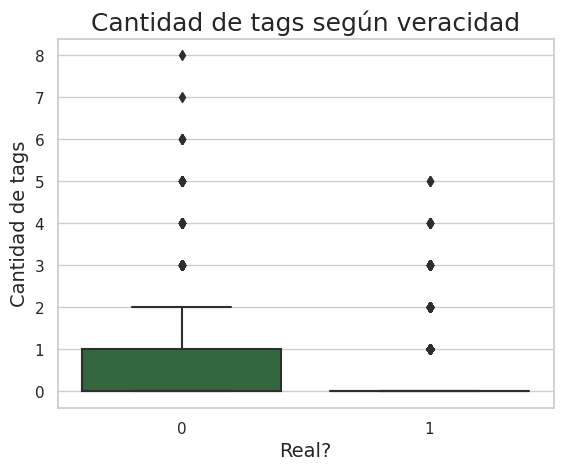

In [87]:
# grafico esto para ver si hay relación
g = sns.boxplot(x="target", y="tags_count", 
                     data=tweets, palette="cubehelix")
g.set_title("Cantidad de tags según veracidad", fontsize=18)
g.set_xlabel("Real?", fontsize=14)
g.set_ylabel("Cantidad de tags", fontsize=14)

### Matriz de correlación para ver cómo se relacionan las variables entre sí

In [88]:
tweets.corr()

,id,target,url_count,hashtags_count,tags_count
id,1.00,0.06,0.01,0.00,-0.03
target,0.06,1.00,0.20,0.05,-0.10
url_count,0.01,0.20,1.00,0.17,-0.22
hashtags_count,0.00,0.05,0.17,1.00,-0.04
tags_count,-0.03,-0.10,-0.22,-0.04,1.00


### Análisis de location

In [81]:
tweets_location = tweets[['location', 'target']]
# a los que no tienen location les pongo un string unknown
tweets_location['location'] = tweets_location.location.fillna('unknown')
tweets_location.location.value_counts()

unknown                     2533
USA                          104
New York                      71
United States                 50
London                        45
                            ... 
No ID, No VOTE!!!              1
someplace living my life       1
Los Angeles for now            1
denver colorado                1
The Desert                     1
Name: location, Length: 3342, dtype: int64

In [ ]:
# tweets donde la location tiene caracteres especiales


In [49]:
grouped_location = tweets_location.groupby(['location'])

In [45]:
grouped_location['target'].count()

location
                          1
  Glasgow                 1
  Melbourne, Australia    1
  News                    1
  å_                      1
                         ..
å_: ?? ÌÑ ? : ?           1
å_å_Los Mina Cityã¢      1
å¡å¡Midwest Û¢Û¢        1
åÊ(?Û¢`?Û¢å«)??         1
åø\_(?)_/åø               1
Name: target, Length: 3342, dtype: int64

In [ ]:
sns.scatterplot(x="Length (Duration)", y="Popularity", data=tweets_location, hue="target")